In [1]:
""" Libraries """
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import psycopg2
import pandas as pd
import nbimporter
from Core import decode_morton

In [2]:
""" Database Connection """
conn_params = "dbname='trajectory' user='postgres' host='localhost' password='990721' port=5432"
conn = psycopg2.connect(conn_params)
cur = conn.cursor()

In [3]:
depth_tree = 6

In [4]:
sql_scatter = """
SELECT indexing_key/64::INTEGER AS indexing_key, sum(st_length(geometry)) AS length
FROM traj_{}
GROUP BY indexing_key/64::INTEGER;
""".format(depth_tree)

cur.execute(sql_scatter)
records = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df_s = pd.DataFrame(records, columns=columns)

sql_box = """
SELECT indexing_key AS indexing_key, sum(st_length(geometry)) AS length
FROM traj_{}
GROUP BY indexing_key;
""".format(depth_tree)

cur.execute(sql_box)
records = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df_b = pd.DataFrame(records, columns=columns)
cur.close()
conn.close()

In [5]:
df_s[["x", "y", "z"]] = df_s.apply(lambda x: decode_morton(int(x["indexing_key"]), 5), axis=1, result_type='expand')
df_b[["x", "y", "z"]] = df_b.apply(lambda x: decode_morton(int(x["indexing_key"]), 6), axis=1, result_type='expand')
df_s.drop(columns=['indexing_key'], inplace=True)
df_b.drop(columns=['indexing_key'], inplace=True)
df_b = df_b.groupby(['x', 'y'])['length'].sum().reset_index()

In [6]:
df_s['length'] = df_s['length'] / df_s['length'].max()
df_b['length'] = df_b['length'] / df_b['length'].max()
cmap = plt.get_cmap('viridis')
color_s = cmap(df_s['length'])
color_b = cmap(df_b['length'])
color_m = cmap([df_b['length'].min()])

C:\Users\23100\AppData\Local\Temp\ipykernel_4880\2838227635.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df_s['x'] * 4, df_s['y'] * 4, df_s['z'] * 4, s=pow(df_s['length'], 3) * 150, c=color_s, cmap='viridis', edgecolor='none')


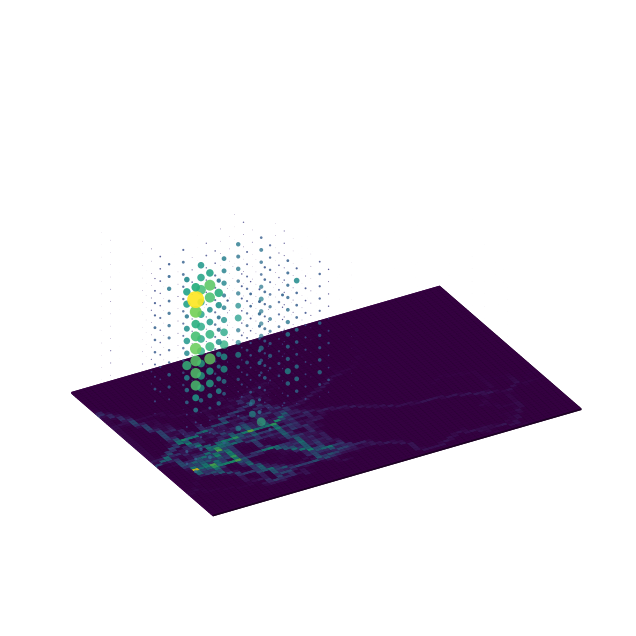

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_s['x'] * 4, df_s['y'] * 4, df_s['z'] * 4, s=pow(df_s['length'], 3) * 150, c=color_s, cmap='viridis', edgecolor='none')

box_size = np.array([1, 1, 0.5])

for i in range(len(df_b)):
    x_corner = df_b.iloc[i]['x'] - box_size[0] / 2
    y_corner = df_b.iloc[i]['y'] - box_size[1] / 2
    z_corner = 0
    length = df_b.iloc[i]['length']
    if length > 0.005:
        ax.bar3d(x_corner, y_corner, z_corner, box_size[0], box_size[1], box_size[2], color=color_b[i], edgecolor='none', shade='none')
    else:
        ax.bar3d(x_corner, y_corner, z_corner, box_size[0], box_size[1], box_size[2], color=color_m[0], edgecolor='none', shade='none')

# Remove grid lines
ax.grid(False)
# Remove axis lines
ax.set_axis_off()
# Remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_box_aspect([1, 1.5, 0.75])
ax.set_proj_type('ortho')
ax.view_init(elev=30, azim=-30, roll=0)
plt.show()
fig.savefig("figs/cover.pdf")